In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Jun 13 16:26:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install gputil
# !pip install psutil
# !pip install humanize

In [ ]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# def printm():
#   GPUs = GPU.getGPUs()
#   gpu = GPUs
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [3]:
!cp /content/drive/MyDrive/Viettel2/train_n.csv /content
!cp /content/drive/MyDrive/Viettel2/test_n.csv /content

In [1]:
import torch 
from torch import nn 
import pandas as pd 
import numpy as np 
from torch.utils.data import Dataset,DataLoader,random_split
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence 
from torch import optim 
from sklearn.metrics import accuracy_score,classification_report
import time 
import pickle

In [5]:
train=pd.read_csv('train_n.csv')
test=pd.read_csv('test_n.csv')

In [6]:
train

,text,label
0,sexy ngôn_ngữ mới miêu_tả quần_vợt nữ nga tay_...,0
1,bull đến 19 h00 ngày 512 đoàn việt nam đã đoạ...,0
2,arsenal khó_nhọc trở_lại vị_trí nhì bảng đội đ...,0
3,đoàn thể_thao khuyết_tật vn thắng_lợi trở_về n...,0
4,các đội mạnh dễ_thở ở serie a đương_kim vô_địc...,0
...,...,...
33754,đan trường tổ_chức live show thứ 4 mãi_mãi một...,9
33755,phạm thanh thảo khó_khăn đã lùi vào quá_khứ bư...,9
33756,trần thùy linh tự nhận là người trưởng_thành m...,9
33757,điệp_viên 007 chỉ trích westlife pierce brosn...,9


In [ ]:
n_samples=len(train)
weights[]
for i in range(10):
    weights.append(len(train[train.label==i]))
weights=[np.log10(n_samples/value) for value in weights]
weight=torch.tensor(weights)

In [ ]:
val=train[train.label==0].sample(int(len(train[train.label==0])*0.25))
for i in range(1,10,1):
  temp=train[train.label==i]
  temp1=temp.sample(int(len(temp)*0.25))
  val=pd.concat([val,temp1],axis=0)

In [ ]:
data_train=train[~train.index.isin(val.index)]
data_val=val
data_train=data_train.sample(frac=1)
data_val=data_val.sample(frac=1)
data_train.to_csv('train1.csv',index=False)
data_val.to_csv('val.csv',index=False)

In [ ]:
!cp /content/train1.csv /content/drive/MyDrive/Viettel2/DeepLearning/
!cp /content/val.csv /content/drive/MyDrive/Viettel2/DeepLearning/

In [7]:
class Vocabulary:
  def __init__(self):
    self.vocab_size=100000
    self.tokenizer=Tokenizer(num_words=self.vocab_size,
          filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
          oov_token='<unk>'
          )
    
  def __len__(self):
    return len(self.tokenizer.word_index)
    
  def build_vocab(self,texts):
    self.tokenizer.fit_on_texts(texts)
    self.tokenizer.word_index['<pad>']=0
    self.tokenizer.index_word[0]='<pad>'
    self.stoi=self.tokenizer.word_index
    self.itos=self.tokenizer.index_word 
  
  def convert_text_to_int(self,text):
    return self.tokenizer.texts_to_sequences([text])[0]

class News(Dataset):
  def __init__(self,file_data,vocab=None):
    self.data=pd.read_csv(file_data)
    self.texts=self.data.text
    self.labels=self.data.label
    if vocab is None:
      self.vocab=Vocabulary()
      self.vocab.build_vocab(self.texts.tolist())
    else:
      self.vocab=vocab
    
  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    #print(idx,"-----------",text)
    text_to_int=self.vocab.convert_text_to_int(text)
    #print(text_to_int)
    return torch.tensor(text_to_int),torch.tensor([label])

class MyCollate:
  def __init__(self,pad_idx):
    self.pad_idx=pad_idx

  def __call__(self,batch):
    texts=[item[0] for item in batch]
    labels=[item[1] for item in batch]
    labels=torch.cat(labels,dim=0)
    texts=pad_sequence(texts,batch_first=True,padding_value=self.pad_idx)
    return texts,labels

In [8]:
batch_size=16
train_dataset=News('train1.csv')
pad_idx=train_dataset.vocab.stoi['<pad>']
def get_loader(loader):
  return DataLoader(dataset=loader,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2,
                    pin_memory=True,
                    collate_fn=MyCollate(pad_idx))
  

In [ ]:
with open('/content/drive/MyDrive/Viettel2/DeepLearning/vocab.pickle','wb') as file:
    pickle.dump(train_dataset.vocab,file,protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# train_size=int(0.8*len(train_dataset))
# val_size=len(train_dataset)-train_size
# train,val=random_split(train_dataset,[train_size,val_size])
# train_loader=get_loader(train)
# val_loader=get_loader(val)

In [10]:
print(len(train_dataset.vocab))

101427


In [11]:
train_loader=get_loader(train_dataset)
val_dataset=News('val.csv',train_dataset.vocab)
val_loader=get_loader(val_dataset)
test_dataset=News('test.csv',train_dataset.vocab)

In [12]:
test_loader=DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=2,
                        pin_memory=True,
                        collate_fn=MyCollate(pad_idx=test_dataset.vocab.stoi['<pad>']))

In [13]:
# for idx,(texts,labels) in enumerate(val_loader):
#   print(texts.size(),' ',labels.size())

In [14]:
# for idx,(texts,labels) in enumerate(test_loader):
#   print(texts.size(),' ',labels.size())

In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class Model(nn.Module):
  def __init__(self,embedding_size,hidden_size,vocab_size,num_class,drop_prob=0.2):
    super(Model,self).__init__()
    self.embedding_size=embedding_size
    self.hidden_size=hidden_size
    self.num_class=num_class
    self.embedding=nn.Embedding(vocab_size,self.embedding_size)
    self.lstm=nn.LSTM(input_size=embedding_size,
                      hidden_size=hidden_size,
                      batch_first=True,
                      num_layers=2,
                      bidirectional=True)
    self.dropout=nn.Dropout(drop_prob)
    self.linear=nn.Linear(hidden_size*4,num_class)
  
  def forward(self,texts):
    #texts: batch_size*seq_length
    embedded=self.embedding(texts)#batch_size*seq_length*embedding_size
    #lstm_out: batch_size*seq_length*(2*hidden_size)
    lstm_out,_=self.lstm(embedded)
    avg_hidden=torch.mean(lstm_out,dim=1)
    max_hidden,_=torch.max(lstm_out,dim=1)
    input_linear=torch.cat((avg_hidden,max_hidden),dim=1)
    out=self.linear(input_linear)
    return out


In [17]:
embedding_size=300
hidden_size=256
vocab_size=train_dataset.vocab.vocab_size
num_class=10

In [ ]:
model=Model(embedding_size,hidden_size,vocab_size,num_class).to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-4)
criterion=nn.CrossEntropyLoss(weight=weight)

In [ ]:
n_epochs=100
loss_train_history=[]
loss_val_history=[]

In [ ]:
def evaluate():
  model.eval()
  loss_val=0
  for idx,(texts,labels) in enumerate(val_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    out=model(texts)
    loss1=criterion(out.view(-1,num_class),labels.reshape(-1))
    loss_val+=loss1.item()
  return loss_val/len(val_loader)

In [ ]:
def testing():
  model.eval()
  final_preds=[]
  final_targets=[]
  with torch.no_grad():
    for ix,(texts,labels) in enumerate(test_loader):
      texts=texts.to(device)
      labels=labels.to(device)
      outputs=model(texts)
      outputs=torch.softmax(outputs,dim=1)
      preds=torch.argmax(outputs,dim=1)
      final_preds.extend(preds.cpu().numpy().tolist())
      final_targets.extend(labels.cpu().numpy().tolist())
  
  print("Accuracy for data test:",accuracy_score(final_targets,final_preds))
  
def save_checkpoint(epoch):
  train_loss=np.asarray(loss_train_history)
  np.save('/content/drive/MyDrive/Viettel/DeepLearning/train{}.npy'.format(epoch),train_loss)
  val_loss=np.asarray(loss_val_history)
  np.save('/content/drive/MyDrive/Viettel/DeepLearning/val{}.npy'.format(epoch),val_loss)
  print("Save loss done")
  model_state={
      'optimizer':optimizer.state_dict(),
      'epoch':epoch,
      'model':model.state_dict()
  }
  torch.save(model_state,'/content/drive/MyDrive/Viettel/DeepLearning/model{}.pth'.format(epoch))
  print("Save model done")

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1583
528
3149


In [ ]:
for epoch in range(n_epochs):
  model.train()
  loss_temp=0
  start_time=time.time()
  for idx,(texts,labels) in enumerate(train_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    out=model(texts)
    #print(out.size())
    loss=criterion(out.view(-1,num_class),labels.reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_temp+=loss.item()
    if idx%100==0:
      print(idx,end=' ')
  print()
  loss_val=evaluate()
  loss_val_history.append(loss_val)
  loss_temp=loss_temp/ blen(train_loader)
  loss_train_history.append(loss_temp)
  print(f"Epoch {epoch}---Train:{loss_temp}---Val:{loss_val}---Time:{time.time()-start_time}")

  if epoch!=0 and epoch%5==0:
    print("--------------Time for testing-----------------")
    testing()  
    save_checkpoint(epoch)
    




0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 0---Train:1.4678066545698512---Val:0.9093450524025795---Time:349.8088686466217
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 1---Train:0.6932721471135103---Val:0.5929851114721687---Time:359.4210407733917
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 2---Train:0.46840797393186817---Val:0.5162431510080668---Time:359.3791081905365
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 3---Train:0.39371014082956113---Val:0.44605390208942647---Time:361.85755133628845
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 4---Train:0.3062756325418879---Val:0.411931687592049---Time:361.66653203964233
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 
Epoch 5---Train:0.2502830228153487---Val:0.4001721169721956---Time:364.2526812553406
--------------Time for testing-----------------
Accuracy for data test: 

In [ ]:
# import pickle 
# with open('/content/drive/MyDrive/Viettel/DeepLearning/dataset.pickle','wb') as file:
#   pickle.dump(train_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/Viettel/DeepLearning/val_dataset.pickle','wb') as file:
#   pickle.dump(val_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/Viettel/DeepLearning/test_dataset.pickle','wb') as file:
#   pickle.dump(test_dataset,file,protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
model_state=torch.load('/content/drive/MyDrive/Viettel/DeepLearning/model55.pth')
model=Model(embedding_size,hidden_size,vocab_size,num_class).to(device)
model.load_state_dict(model_state['model'])

<All keys matched successfully>

In [19]:
final_preds=[]
final_true=[]
model.eval()
with torch.no_grad():
  for idx,(texts,labels) in enumerate(train_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    outs=model(texts)
    outs=torch.softmax(outs,dim=1)
    preds=torch.argmax(outs,dim=1)
    final_preds.extend(preds.cpu().numpy())
    final_true.extend(labels.cpu().numpy())
    if idx%200==0:
      print(idx,end=" ")


0 200 400 600 800 1000 1200 1400 

In [20]:
result=accuracy_score(final_true,final_preds)
print("Accuracy for train",result)

Accuracy for train 0.9988152594581786


In [ ]:
final_preds=[]
final_true=[]
model.eval()
with torch.no_grad():
  for idx,(texts,labels) in enumerate(test_loader):
    texts=texts.to(device)
    labels=labels.to(device)
    outs=model(texts)
    outs=torch.softmax(outs,dim=1)
    preds=torch.argmax(outs,dim=1)
    final_preds.extend(preds.cpu().numpy())
    final_true.extend(labels.cpu().numpy())
    if idx%200==0:
      print(idx,end=" ")


0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 

In [ ]:
labels={0:"The thao",
1:"Phap luat",
2:"Khoa hoc",
3:"Suc khoe",
4:"Chinh tri Xa hoi",
5:"Doi song",
6:"The gioi",
7:"Kinh doanh",
8:"Vi tinh",
9:"Van hoa"}

In [ ]:
result=accuracy_score(final_true,final_preds)
print("Accuracy for train",result)

Accuracy for train 0.8908145236535445


In [ ]:
print(classification_report(final_true,final_preds,target_names=list(labels.values())))

                  precision    recall  f1-score   support

        The thao       0.97      0.98      0.98      6667
       Phap luat       0.88      0.91      0.90      3788
        Khoa hoc       0.72      0.75      0.74      2096
        Suc khoe       0.93      0.90      0.92      5417
Chinh tri Xa hoi       0.86      0.84      0.85      7567
        Doi song       0.66      0.60      0.63      2036
        The gioi       0.94      0.90      0.92      6716
      Kinh doanh       0.86      0.90      0.88      5276
         Vi tinh       0.91      0.94      0.92      4560
         Van hoa       0.90      0.94      0.92      6250

        accuracy                           0.89     50373
       macro avg       0.86      0.86      0.86     50373
    weighted avg       0.89      0.89      0.89     50373



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
temp=confusion_matrix(final_true,final_preds)

In [ ]:
df=pd.DataFrame(temp,index=labels.values(),columns=labels.values()).astype(int)

In [ ]:
df

,The thao,Phap luat,Khoa hoc,Suc khoe,Chinh tri Xa hoi,Doi song,The gioi,Kinh doanh,Vi tinh,Van hoa
The thao,6535,14,17,2,19,12,16,5,9,38
Phap luat,25,3431,2,5,201,31,14,52,10,17
Khoa hoc,6,3,1573,102,71,123,57,32,84,45
Suc khoe,12,18,202,4885,81,109,58,39,8,5
Chinh tri Xa hoi,38,270,84,106,6335,126,76,310,93,129
Doi song,18,31,118,67,145,1214,36,47,39,321
The gioi,54,31,102,40,92,66,6014,171,54,92
Kinh doanh,4,55,12,9,267,28,49,4723,117,12
Vi tinh,9,8,33,8,32,31,22,122,4266,29
Van hoa,28,17,37,7,95,97,39,3,30,5897


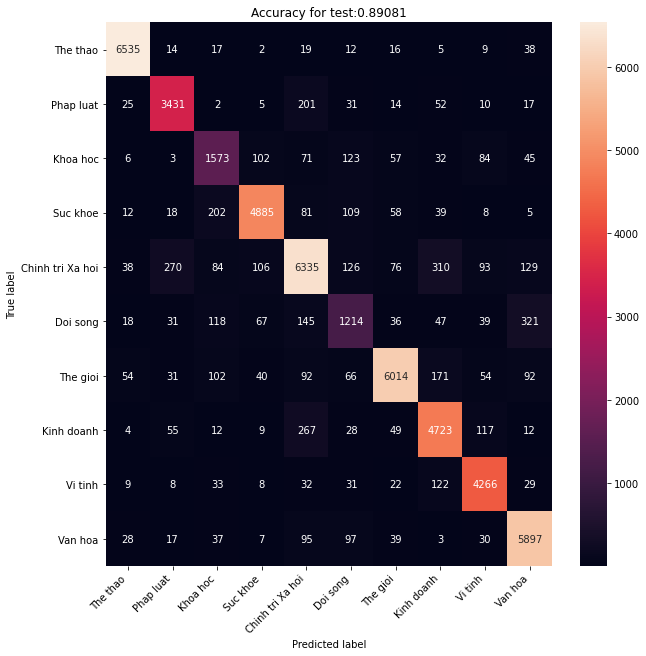

In [ ]:
plt.figure(figsize=(10,10))
heatmap=sns.heatmap(df,annot=True,fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0,ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),rotation=45,ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Accuracy for test:{:0.5f}".format(result))
plt.savefig('/content/drive/MyDrive/Viettel/DeepLearning/result.png')